In [1]:
import warnings

warnings.filterwarnings(action="ignore")

try:
    %matplotlib inline
    %reload_ext lab_black
except Exception as e:
    print(e)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import KFold
import xgboost as xgb
import lightgbm as lgb

In [2]:
train_df = pd.read_csv("data/train.csv", index_col="id")
test_df = pd.read_csv("data/test.csv", index_col="id")
submission = pd.read_csv("data/sample_submission.csv", index_col="id")

train_df.shape, test_df.shape, submission.shape

((10000, 75), (10000, 71), (10000, 4))

# Missing Value

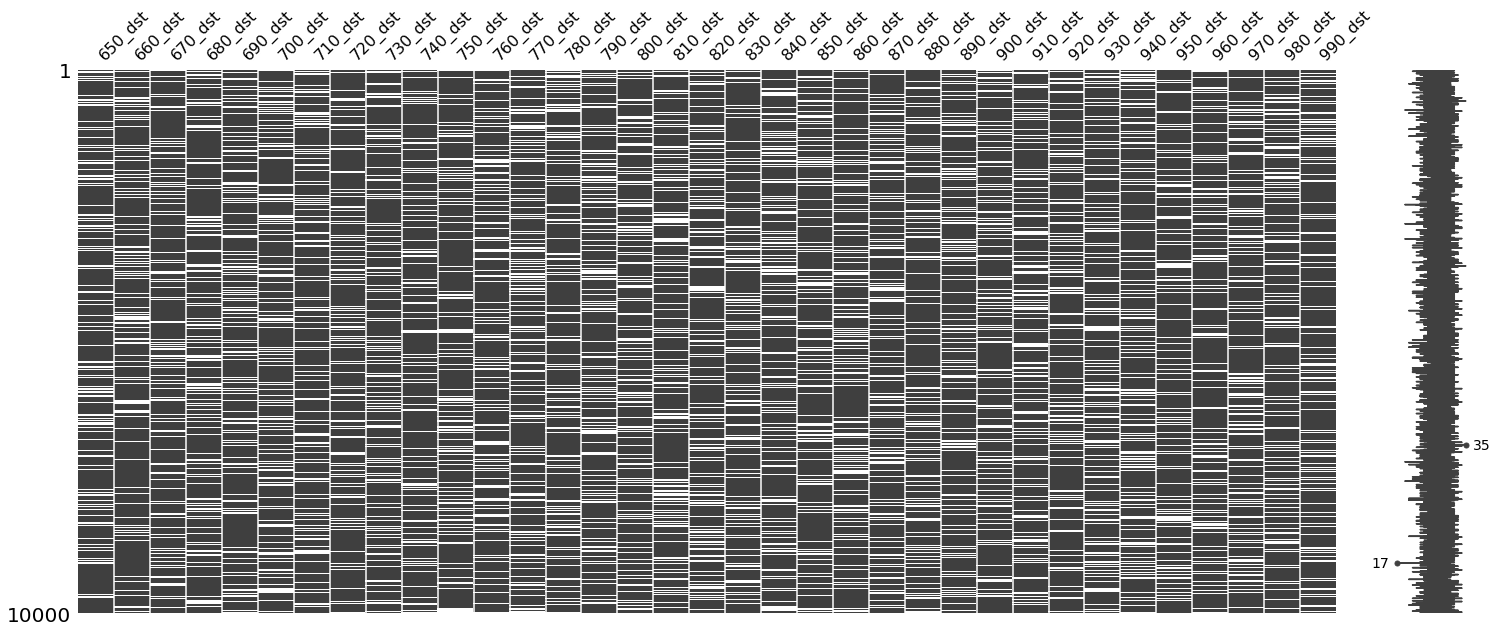

In [3]:
msno.matrix(
    train_df, filter="bottom", n=np.count_nonzero(train_df.isna().sum()), p=0.9999,
)

## Interpolation

In [4]:
train_y = train_df.iloc[:, -4:]
train_src = train_df.filter(regex="src")
train_dst = train_df.filter(regex="dst").interpolate(methods="linear")

train_df.update(train_dst)

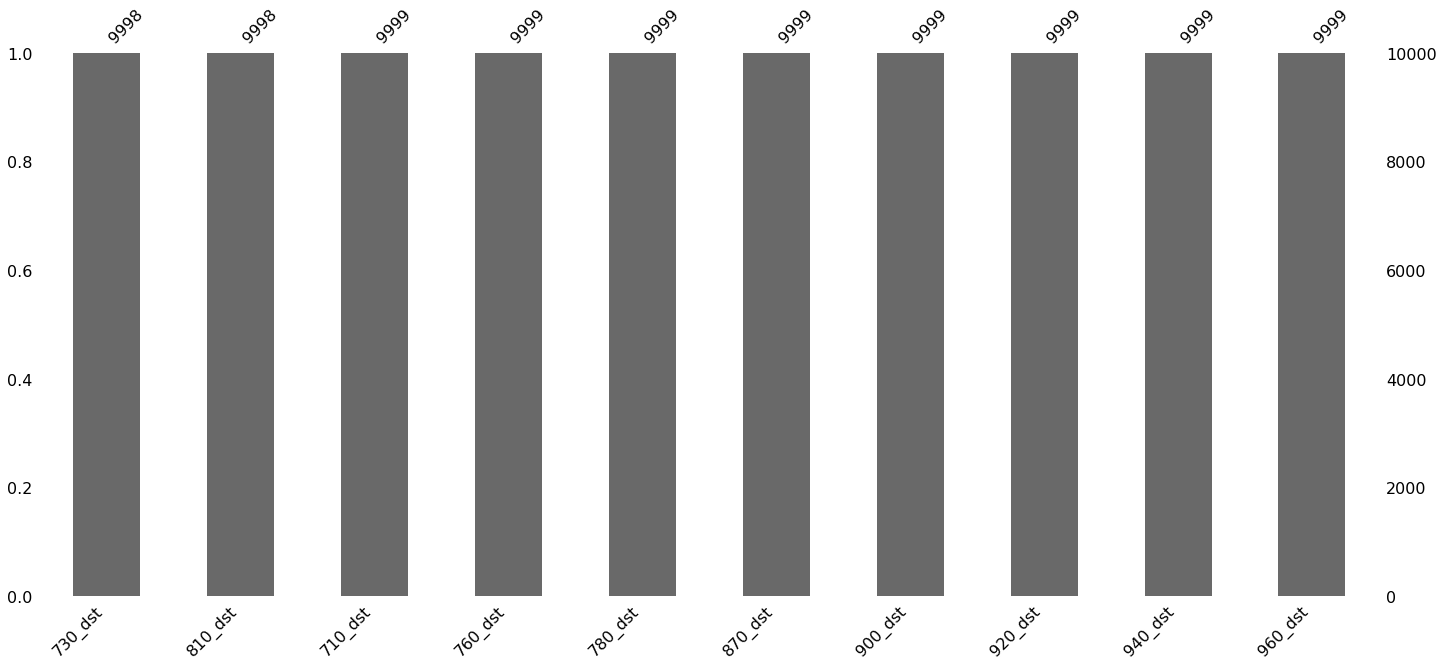

In [5]:
msno.bar(
    train_df,
    filter="bottom",
    n=np.count_nonzero(train_df.isna().sum()),
    p=0.9999,
    sort="ascending",
)

## Imputation

In [6]:
def impute(data, columns):
    for x, y in sorted(columns, key=lambda k: k[0], reverse=True):
        data.loc[data[x].isna(), x] = data.loc[data[x].isna(), y]

In [7]:
impute(
    train_df,
    [
        ("730_dst", "740_dst"),
        ("810_dst", "820_dst"),
        ("710_dst", "720_dst"),
        ("760_dst", "770_dst"),
        ("780_dst", "790_dst"),
        ("870_dst", "880_dst"),
        ("900_dst", "910_dst"),
        ("920_dst", "930_dst"),
        ("940_dst", "950_dst"),
        ("960_dst", "970_dst"),
    ],
)

# Hyperparameter

In [8]:
from sklearn.model_selection import KFold, GridSearchCV

param_grid = {
    "num_leaves": [59, 63, 57],
    "n_estimators": [150, 200, 250],
}

kfold = KFold(n_splits=5, shuffle=True, random_state=None)

estimator = lgb.LGBMRegressor()
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=kfold)

grid_search.fit(train_df.iloc[:, :-4], train_y["hbo2"])

grid_search.best_params_

{'n_estimators': 150, 'num_leaves': 57}

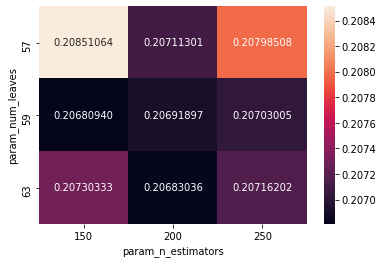

In [9]:
sns.heatmap(
    pd.DataFrame(grid_search.cv_results_).pivot(
        index="param_num_leaves", columns="param_n_estimators", values="mean_test_score"
    ),
    annot=True,
    fmt=".8f",
)

In [10]:
# https://lightgbm.readthedocs.io/en/latest/Parameters.html
params = {
    "objective": "mae",
    # "boosting": "gbdt",
    "num_iterations": 150,
    "learning_rate": 0.1,
    "num_leaves": 57,
    "max_depth": -1,
    "is_provide_training_metric": True,
}

# Training

## Cross Validation

In [11]:
# src, dst
for label in train_y.columns:
    print(label)
    _ = lgb.cv(
        params,
        train_set=lgb.Dataset(
            data=train_df.filter(regex="src|dst"), label=train_y[label],
        ),
        nfold=5,
        stratified=False,
        shuffle=True,
        verbose_eval=params["num_iterations"],
        eval_train_metric=True,
    )
    print()

hhb
[150]	cv_agg's train l1: 1.00521 + 0.00981728	cv_agg's valid l1: 1.66949 + 0.0251909

hbo2
[150]	cv_agg's train l1: 0.460629 + 0.00453097	cv_agg's valid l1: 0.756304 + 0.0106894

ca
[150]	cv_agg's train l1: 1.33036 + 0.0243291	cv_agg's valid l1: 2.20169 + 0.0229973

na
[150]	cv_agg's train l1: 0.85967 + 0.0195248	cv_agg's valid l1: 1.41267 + 0.0289428



In [12]:
# rho, src, dst
for label in train_y.columns:
    print(label)
    _ = lgb.cv(
        params,
        train_set=lgb.Dataset(
            data=train_df.filter(regex="rho|src|dst"), label=train_y[label],
        ),
        nfold=5,
        stratified=False,
        shuffle=True,
        verbose_eval=params["num_iterations"],
        eval_train_metric=True,
    )
    print()

hhb
[150]	cv_agg's train l1: 0.707866 + 0.00268303	cv_agg's valid l1: 1.23835 + 0.0259785

hbo2
[150]	cv_agg's train l1: 0.427324 + 0.00424116	cv_agg's valid l1: 0.717152 + 0.011114

ca
[150]	cv_agg's train l1: 1.25986 + 0.0168789	cv_agg's valid l1: 2.11019 + 0.0250454

na
[150]	cv_agg's train l1: 0.849996 + 0.0140165	cv_agg's valid l1: 1.41101 + 0.0301545



## Model

In [13]:
models = {}

In [14]:
def train(X, y):
    models = []
    kfold = KFold(n_splits=10, shuffle=True, random_state=None)

    for train_idx, valid_idx in kfold.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMRegressor(random_state=None, silent=False, **params)

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=params["num_iterations"],
        )
        models.append(model)

    return models

In [15]:
for label in train_y.columns:
    print(label)
    _ = train(train_df.filter(regex="rho|src|dst"), train_y[label])
    print()

hhb
[150]	training's l1: 0.720139	valid_1's l1: 1.23584
[150]	training's l1: 0.725253	valid_1's l1: 1.19057
[150]	training's l1: 0.716327	valid_1's l1: 1.23007
[150]	training's l1: 0.76046	valid_1's l1: 1.24544
[150]	training's l1: 0.727591	valid_1's l1: 1.19322
[150]	training's l1: 0.722152	valid_1's l1: 1.22945
[150]	training's l1: 0.718587	valid_1's l1: 1.17463
[150]	training's l1: 0.725556	valid_1's l1: 1.27167
[150]	training's l1: 0.727061	valid_1's l1: 1.22473
[150]	training's l1: 0.721296	valid_1's l1: 1.18749

hbo2
[150]	training's l1: 0.436219	valid_1's l1: 0.722108
[150]	training's l1: 0.439893	valid_1's l1: 0.728198
[150]	training's l1: 0.439225	valid_1's l1: 0.709835
[150]	training's l1: 0.435892	valid_1's l1: 0.715605
[150]	training's l1: 0.432864	valid_1's l1: 0.745161
[150]	training's l1: 0.444319	valid_1's l1: 0.723369
[150]	training's l1: 0.4386	valid_1's l1: 0.709285
[150]	training's l1: 0.434355	valid_1's l1: 0.696891
[150]	training's l1: 0.440595	valid_1's l1: 0.698

In [16]:
def train_categorical(X, y):
    models = []
    kfold = KFold(n_splits=10, shuffle=True, random_state=None)

    for train_idx, valid_idx in kfold.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMRegressor(random_state=None, silent=False, **params)

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=params["num_iterations"],
            categorical_feature=["rho"],
        )
        models.append(model)

    return models

In [17]:
for label in train_y.columns:
    print(label)
    _ = train_categorical(train_df.filter(regex="rho|src|dst"), train_y[label])
    print()

hhb
[150]	training's l1: 0.72109	valid_1's l1: 1.23532
[150]	training's l1: 0.739865	valid_1's l1: 1.31552
[150]	training's l1: 0.71621	valid_1's l1: 1.26739
[150]	training's l1: 0.719428	valid_1's l1: 1.22469
[150]	training's l1: 0.723124	valid_1's l1: 1.21584
[150]	training's l1: 0.715059	valid_1's l1: 1.15883
[150]	training's l1: 0.716258	valid_1's l1: 1.21237
[150]	training's l1: 0.720779	valid_1's l1: 1.16764
[150]	training's l1: 0.73256	valid_1's l1: 1.1743
[150]	training's l1: 0.735741	valid_1's l1: 1.2437

hbo2
[150]	training's l1: 0.437572	valid_1's l1: 0.743193
[150]	training's l1: 0.446606	valid_1's l1: 0.684464
[150]	training's l1: 0.435242	valid_1's l1: 0.723631
[150]	training's l1: 0.439808	valid_1's l1: 0.720699
[150]	training's l1: 0.43737	valid_1's l1: 0.711349
[150]	training's l1: 0.440268	valid_1's l1: 0.740861
[150]	training's l1: 0.437097	valid_1's l1: 0.691409
[150]	training's l1: 0.444477	valid_1's l1: 0.711441
[150]	training's l1: 0.43705	valid_1's l1: 0.713657


# Prediction

## Preprocessing

In [18]:
test_dst = test_df.filter(regex="dst").interpolate(methods="linear")

test_df.update(test_dst)

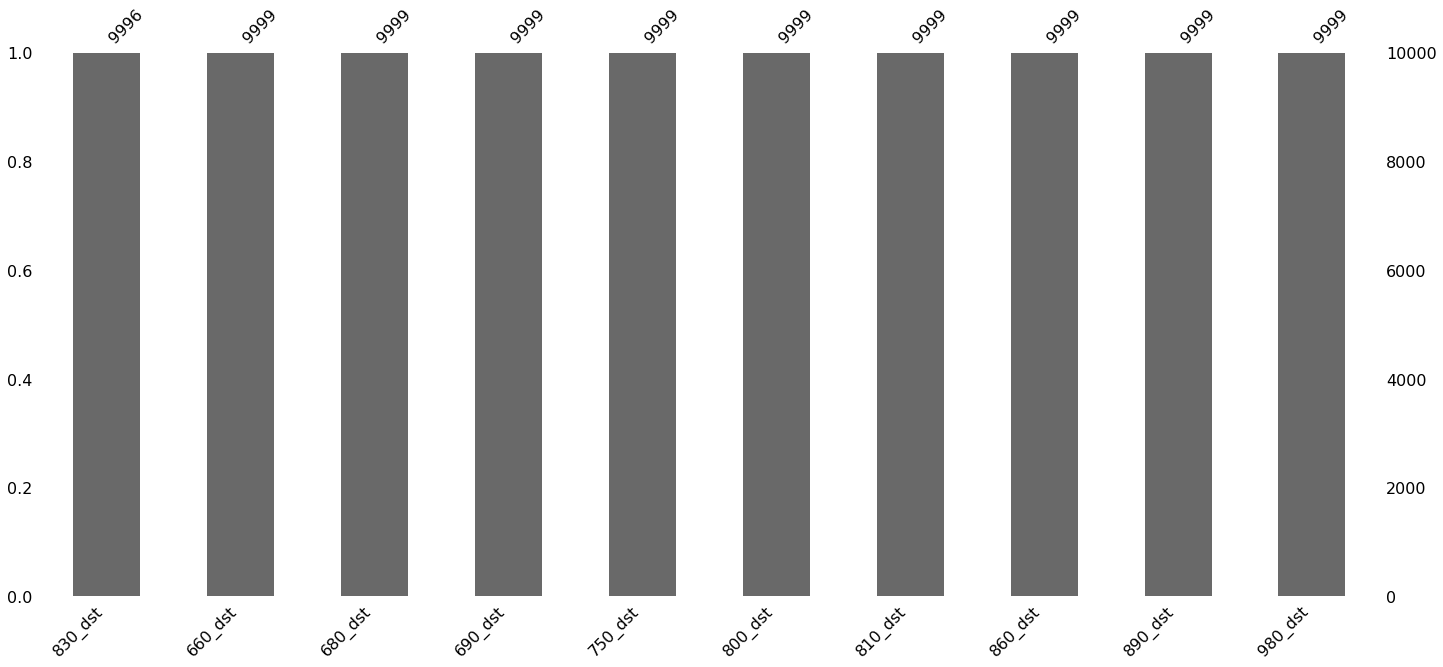

In [19]:
msno.bar(
    test_df,
    filter="bottom",
    n=np.count_nonzero(train_df.isna().sum()),
    p=0.9999,
    sort="ascending",
)

In [20]:
impute(
    test_df,
    [
        ("830_dst", "840_dst"),
        ("660_dst", "670_dst"),
        ("680_dst", "690_dst"),
        ("690_dst", "700_dst"),
        ("750_dst", "760_dst"),
        ("800_dst", "810_dst"),
        ("810_dst", "820_dst"),
        ("860_dst", "890_dst"),
        ("890_dst", "900_dst"),
        ("980_dst", "990_dst"),
    ],
)

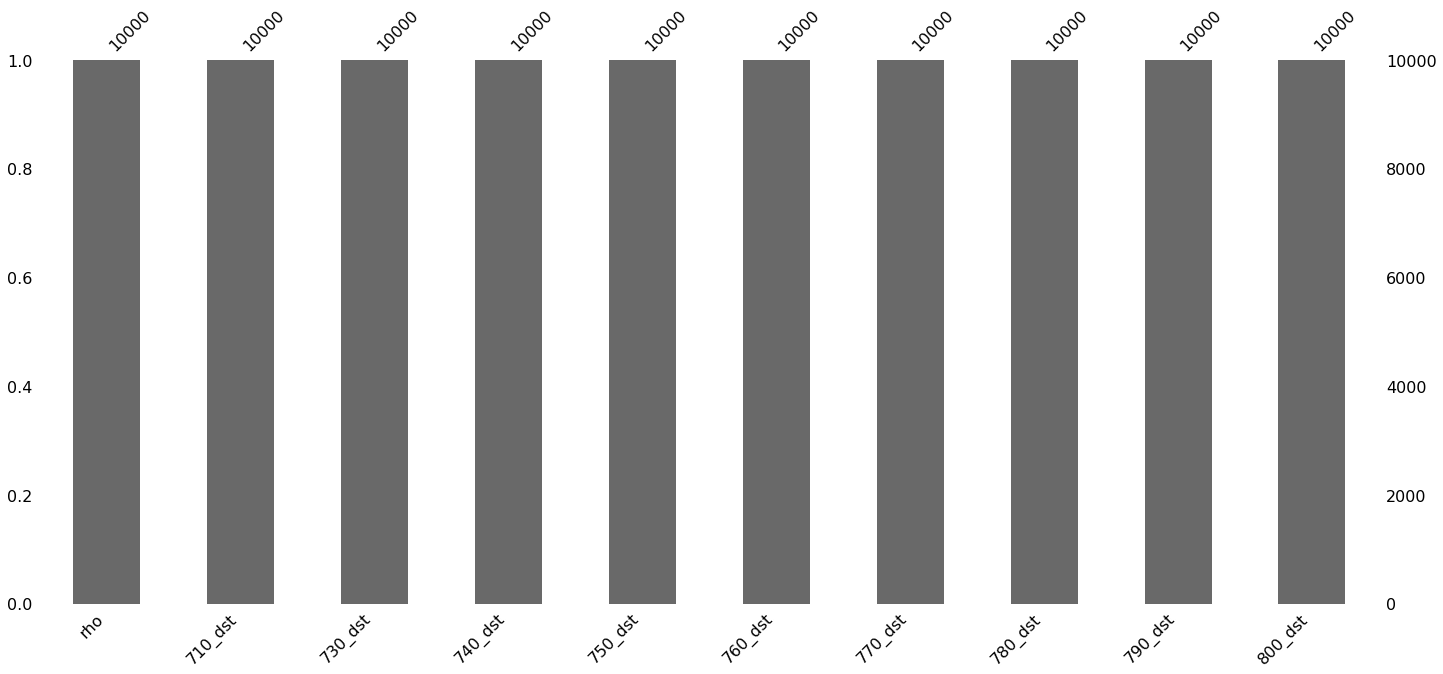

In [21]:
msno.bar(test_df, filter="bottom", n=10, sort="ascending", labels=True)

## Predict

In [ ]:
for key in models:
    predictions = []
    for model in models[key]:
        predictions.append(model.predict(test_df))
    submission[key] = np.mean(predictions, axis=0)